# Delays

The objective of this script is to compute bus delays in Warsaw. The delays are determined by analyzing data from two sources:
1. The 'timetable.csv' file, which was generated by the previous script and provides information about where a particular bus should be at a specific time.
2. API requests that provide real-time information about the current location of the buses.

Importing the needed libraries

In [90]:
import urllib.request, json
import requests
from dateutil.relativedelta import relativedelta
import json
from datetime import datetime, date
import pandas as pd
import seaborn as sns

At this stage, the timetable ('timetable.csv') is loaded, and certain data are removed, while time data is transformed into a more convenient format for further analysis.

In [110]:
timetable = pd.read_csv('timetable.csv', low_memory=False).drop(['Unnamed: 0'], axis = 1)
timetable = timetable[timetable['czas'] <= '23:59:59']
timetable['czas'] = timetable.apply(lambda x: (datetime.strptime(x['czas'], '%H:%M:%S').time()), axis=1)

At this point API is requested to provide real-time information about the current location of the buses. Based on those informations is created 'buses_df' DataFrame, which contains:
1. Line number ('Lines')
2. Vehicle number ('VehicleNumber')
3. Fleet number ('Brigade')
4. Time ('Time')
5. Longitude ('Lon')
6. Latitude ('Lat')

In [92]:
api_key = '0ebc26d4-4da3-4de9-bdcb-cf3b105874a3'
with urllib.request.urlopen("https://api.um.warszawa.pl/api/action/busestrams_get/?apikey={0}&type=1&resource_id=f2e5503e927d-4ad3-9500-4ab9e55deb59".format(api_key)) as url:
        buses = json.loads(url.read().decode())['result']
        buses_df = pd.DataFrame(buses)

DataFrame 'buses_df' is transformed into a more convenient format for further analysis.

In [93]:
buses_df['Time'] = buses_df.apply(lambda x: (datetime.strptime(x['Time'], '%Y-%m-%d %H:%M:%S').time()), axis=1)
buses_df[buses_df['Brigade'] == ' '] = 0

We map the next bus stop according to the timetable for all buses (what should be the bus's next stop if there are no delays). Using this information, we add three more columns to the dataset:
1. Time_stop (This column represents the exact time the bus should arrive at the next stop)
2. Lat_stop (This column represents the longitude of the next bus stop)
3. Lon_stop (This column represents the latitude of the next bus stop)

In [94]:
buses_df['Time_stop'] = ''
buses_df['Lat_stop'] = ''
buses_df['Lon_stop'] = ''

In [95]:
for a in range(len(buses_df)):
    try:
        bry = int(buses_df.iloc[a]['Brigade'])
    except ValueError:
        bry = str(buses_df.iloc[a]['Brigade'])
    df1 = timetable.loc[(timetable['line'] == buses_df.iloc[a]['Lines']) & (timetable['brygada'] == bry)].copy()
    if df1.empty or df1[df1['czas'] >= buses_df.iloc[a]['Time']].sort_values(by=['czas']).empty:
        buses_df.loc[a, 'Time_stop'] = 'no data'
        buses_df.loc[a, 'Lat_stop'] = 'no data'
        buses_df.loc[a, 'Lon_stop'] = 'no data'
    else:
        buses_df.loc[a, 'Time_stop'] = df1[df1['czas'] >= buses_df.iloc[a]['Time']].sort_values(by=['czas']).iloc[0]['czas']
        buses_df.loc[a, 'Lat_stop'] = df1[df1['czas'] >= buses_df.iloc[a]['Time']].sort_values(by=['czas']).iloc[0]['Lat']
        buses_df.loc[a, 'Lon_stop'] = df1[df1['czas'] >= buses_df.iloc[a]['Time']].sort_values(by=['czas']).iloc[0]['Lon']

We remove rows from the dataset where it was impossible to map the next bus stop.

In [100]:
buses_df = buses_df[(buses_df['Time_stop'] != 'no data') & (buses_df['Time_stop'] != '')].reset_index()

We have computed three additional variables for each row in the 'buses_df' DataFrame based on the current data:
1. duration - This represents the time in minutes required to travel from the current location to the location of the next bus stop
2. diff - This represents the difference in minutes between the planned arrival time according to the timetable and the actual arrival time.
3. delay - This represents the delay in minutes, which is the difference between duration variable and diff variable.

In [102]:
buses_df['duration'] = ''
buses_df['diff'] = ''
buses_df['delay'] = ''

Column 'duration' was calculated by requesting access to the OSRM service.

In [103]:
for a in range(len(buses_df)):
        r = requests.get(f"http://router.project-osrm.org/route/v1/car/{buses_df.iloc[a]['Lon']},{buses_df.iloc[a]['Lat']};{buses_df.iloc[a]['Lon_stop']},{buses_df.iloc[a]['Lat_stop']}?overview=false")
        routes = json.loads(r.content)
        route_1 = routes.get("routes")[0]
        buses_df.at[a, 'duration'] = round(route_1.get("duration")/60, 2)

In [104]:
buses_df = buses_df[buses_df['duration'] != '']

The 'diff' column was generated by  substracting the actual arrival time from the planned arrival time

In [106]:
for a in range(len(buses_df)):
    diff = datetime.combine(date.today(), buses_df['Time_stop'].iloc[a]) - datetime.combine(date.today(), buses_df['Time'].iloc[a])
    buses_df.at[a, 'diff'] = diff.total_seconds()/60

The 'delay' column was generated by  substracting 'diff' column from 'duration' column

In [107]:
buses_df['delay'] = buses_df['duration'] - buses_df['diff']

In [108]:
buses_df = buses_df[buses_df['delay'] != '']

The 'buses_df' DataFrame presents data on delays, which are recorded in the 'delay' column. The top 10 highest delays at the current time are displayed below.

In [170]:
buses_df.sort_values(by='delay', ascending=False).head(10)

,Lines,Lon,VehicleNumber,Time,Lat,Brigade,Time_stop,Lat_stop,Lon_stop,Duration,delay,diff
241,105,20.922409,2202,19:11:05,52.221497,1,19:13:00,52.223453,20.930753,25.66,23.743333,1.916667
297,190,20.995224,3413,19:11:03,52.242420,2,19:12:00,52.24228,20.994326,20.9,19.95,0.950000
705,L21,21.216611,70035,16:57:36,52.028983,1,16:58:00,52.032499,21.212314,17.42,17.02,0.400000
774,182,21.097108,7322,19:11:04,52.234772,4,19:14:00,52.236196,21.098363,15.73,12.796667,2.933333
268,105,20.897521,2244,19:11:04,52.221355,4,19:12:00,52.22827,20.897144,13.6,12.666667,0.933333
731,136,21.009047,7231,19:11:05,52.169765,7,19:12:00,52.158081,21.021215,13.37,12.453333,0.916667
290,132,21.060998,3404,19:11:04,52.305147,4,19:14:00,52.312498,21.065619,15.36,12.426667,2.933333
143,106,21.013963,1538,19:10:50,52.240475,1,19:12:00,52.240069,21.016608,13.09,11.923333,1.166667
768,182,20.995232,7316,19:11:04,52.216537,6,19:13:00,52.217168,21.006397,13.51,11.576667,1.933333
771,158,21.070217,7319,19:11:04,52.241999,8,19:13:00,52.240254,21.061899,13.49,11.556667,1.933333


We can also view the information displayed on the chart.

<AxesSubplot:xlabel='Lines', ylabel='delay'>

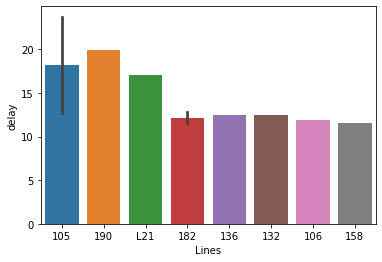

In [171]:
sns.barplot(x='Lines', y='delay',data= buses_df.sort_values(by='delay', ascending=False).head(10))